In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import recbole
aisles = pd.read_csv("../aisles.csv")
departments = pd.read_csv("../departments.csv")

order_products_train = pd.concat([pd.read_csv("../order_products__train.csv"),pd.read_csv('../order_products__prior.csv')],axis=0)
orders = pd.read_csv("../orders.csv")
products = pd.read_csv("../products.csv")

In [2]:
orders["days_since_prior_order"].fillna(0,inplace=True)
orders.sort_values(by=["user_id","order_number"],inplace=True)
orders['days_since_first_order'] = orders.groupby('user_id')['days_since_prior_order'].transform(pd.Series.cumsum)
orders.head(n=30)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order
0,2539329,1,prior,1,2,8,0.0,0.0
1,2398795,1,prior,2,3,7,15.0,15.0
2,473747,1,prior,3,3,12,21.0,36.0
3,2254736,1,prior,4,4,7,29.0,65.0
4,431534,1,prior,5,4,15,28.0,93.0
5,3367565,1,prior,6,2,7,19.0,112.0
6,550135,1,prior,7,1,9,20.0,132.0
7,3108588,1,prior,8,1,14,14.0,146.0
8,2295261,1,prior,9,1,16,0.0,146.0
9,2550362,1,prior,10,4,8,30.0,176.0


In [3]:
combined = pd.merge(order_products_train,orders,how="inner",left_on="order_id",right_on="order_id")
combined = pd.merge(products,combined,how="inner",left_on="product_id",right_on="product_id")
combined = pd.merge(aisles,combined,how="inner",left_on="aisle_id",right_on="aisle_id")
combined = pd.merge(departments,combined,how="inner",left_on="department_id",right_on="department_id")
combined.columns

Index(['department_id', 'department', 'aisle_id', 'aisle', 'product_id',
       'product_name', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'days_since_first_order'],
      dtype='object')

In [4]:
counts = combined["user_id"].value_counts()
counts[counts<4].shape

(99,)

In [5]:
uniques = combined.groupby("user_id")['product_id'].nunique()
combined_subset = combined[combined["user_id"].isin(uniques[uniques>1].index)].copy(deep=True)
combined_subset.shape

(33817284, 16)

In [6]:
combined_subset.sort_values(["user_id","order_number"],inplace=True)

In [7]:
combined_subset["item_weight"] = 1/(combined_subset["days_since_first_order"].max()-combined_subset["days_since_first_order"]+1)
item_weights = combined_subset.groupby(["user_id","product_id"])["item_weight"].agg(["sum","mean"])
last_time_ordered = combined_subset.groupby(["user_id","product_id"])["days_since_first_order"].max().rename("last_time_ordered")
item_weights = item_weights.join(last_time_ordered,on=["user_id","product_id"],how="inner")
final_dataset = item_weights.reset_index()
final_dataset

,user_id,product_id,sum,mean,last_time_ordered
0,1,196,0.043843,0.003986,190.0
1,1,10258,0.041111,0.004111,190.0
2,1,10326,0.003663,0.003663,93.0
3,1,12427,0.038161,0.003816,176.0
4,1,13032,0.018067,0.004517,190.0
...,...,...,...,...,...
13863478,206209,43961,0.013296,0.004432,203.0
13863479,206209,44325,0.003521,0.003521,82.0
13863480,206209,48370,0.005525,0.005525,185.0
13863481,206209,48697,0.003521,0.003521,82.0


In [8]:
final_dataset["sum"].describe()

count    1.386348e+07
mean     1.830664e-02
std      6.033417e-02
min      2.732240e-03
25%      3.257329e-03
50%      5.714286e-03
75%      1.249765e-02
max      2.762225e+00
Name: sum, dtype: float64

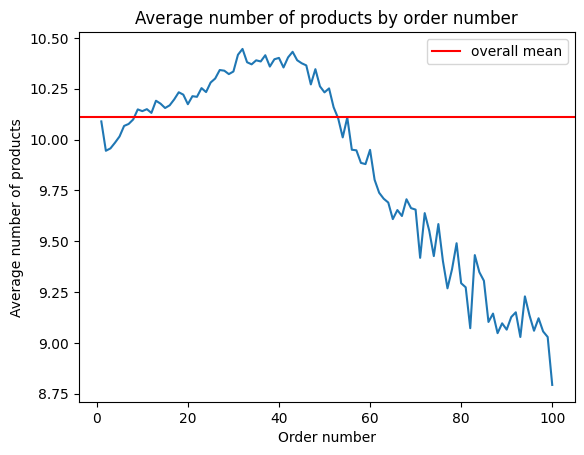

In [9]:
counts_by_order_number = combined_subset.groupby(["user_id","order_number"])["product_id"].count().groupby("order_number").mean()
plt.plot(counts_by_order_number.index,counts_by_order_number.values)
plt.axhline(y = combined_subset.groupby(["user_id","order_number"])["product_id"].count().mean(), color = 'r', linestyle = '-', label = 'overall mean')
plt.ylabel("Average number of products")
plt.xlabel("Order number")
plt.title("Average number of products by order number")
plt.legend()
plt.show()

In [10]:
plt.hist(last_order.values,bins=50)
plt.axvline(x = last_order.values.mean(), color = 'r', linestyle = '-', label = 'overall mean')
plt.ylabel("Count")
plt.xlabel("Products in Last Order")
plt.title("Number of Products in Last Order Distribution")
plt.legend()
plt.show()

NameError: name 'last_order' is not defined

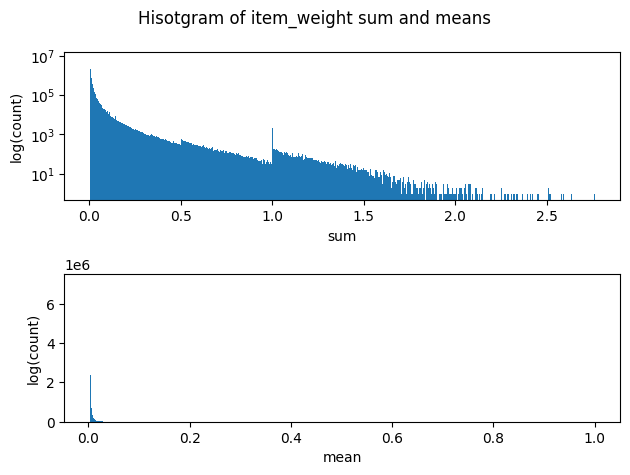

In [11]:
fig, axs = plt.subplots(2,tight_layout=True)
fig.suptitle('Hisotgram of item_weight sum and means')
axs[0].hist(final_dataset["sum"],bins=1000)
axs[0].set_ylabel("log(count)")
axs[0].set_xlabel("sum")
axs[1].hist(final_dataset["mean"],bins=1000)
axs[1].set_ylabel("log(count)")
axs[1].set_xlabel("mean")
axs[0].set_yscale('log')
plt.show()

In [ ]:
final_dataset = pd.merge(final_dataset,products,on="product_id",how="inner").drop(["product_name"],axis=1)
final_dataset

,user_id,product_id,sum,mean,aisle_id,department_id
0,1,196,0.043843,0.003986,77,7
1,15,196,0.030194,0.006039,77,7
2,19,196,0.009078,0.003026,77,7
3,21,196,0.003663,0.003663,77,7
4,31,196,0.006678,0.003339,77,7
...,...,...,...,...,...,...
13863478,200463,8682,0.002976,0.002976,114,17
13863479,203389,8682,0.003401,0.003401,114,17
13863480,202557,43553,0.043811,0.003370,64,7
13863481,203436,42338,0.005581,0.002791,50,19


In [ ]:
final_dataset.sort_values(["user_id","sum"],ascending=True,inplace=True)
final_dataset[final_dataset["user_id"]==206209]

,user_id,product_id,sum,mean,aisle_id,department_id
5942150,206209,14901,0.002732,0.002732,117,19
6157750,206209,890,0.002732,0.002732,81,15
6268117,206209,20842,0.002732,0.002732,120,16
3549440,206209,4591,0.002786,0.002786,130,14
11178628,206209,28590,0.002786,0.002786,49,12
...,...,...,...,...,...,...
79629,206209,13176,0.019097,0.003183,24,4
8595196,206209,41213,0.028301,0.004043,112,3
522984,206209,24852,0.030746,0.006149,24,4
4161017,206209,9405,0.046203,0.004620,91,16


In [ ]:
#verification purposes
# combined_subset[np.logical_and(combined_subset["user_id"]==206209,combined_subset["product_id"]==9405)].sort_values("order_number",ascending=False)

In [12]:
final_dataset.to_csv("orders.inter",index=False,sep="\t")

In [ ]:
unique_items = final_dataset.drop_duplicates(subset=["product_id"]).loc[:,["product_id","aisle_id","department_id"]]
unique_items.to_csv("orders.item",index=False,sep="\t")
unique_items.head()

,product_id,aisle_id,department_id
79630,14084,91,16
115164,30450,88,13
8857,10326,24,4
82739,17122,24,4
142937,41787,24,4


In [ ]:
products_subset = products.loc[:,["product_id","aisle_id","department_id"]]
products_subset = pd.concat([pd.DataFrame([[products_subset.product_id.max()+1,products_subset.aisle_id.max()+1,products_subset.department_id.max()+1]], columns=products_subset.columns), products_subset], ignore_index=True) #representing new order item
products_subset.to_csv("orders.item",index=False,sep="\t")

In [ ]:
combined_subset.sort_values(["user_id","order_number","add_to_cart_order"],ascending=True,inplace=True)
combined_subset.head()

,department_id,department,aisle_id,aisle,product_id,product_name,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_since_first_order,item_weight
14879869,7,beverages,77,soft drinks,196,Soda,2539329,1,0,1,prior,1,2,8,0.0,0.0,0.002732
26112872,16,dairy eggs,91,soy lactosefree,14084,Organic Unsweetened Vanilla Almond Milk,2539329,2,0,1,prior,1,2,8,0.0,0.0,0.002732
30172492,19,snacks,23,popcorn jerky,12427,Original Beef Jerky,2539329,3,0,1,prior,1,2,8,0.0,0.0,0.002732
30233313,19,snacks,23,popcorn jerky,26088,Aged White Cheddar Popcorn,2539329,4,0,1,prior,1,2,8,0.0,0.0,0.002732
28579048,17,household,54,paper goods,26405,XL Pick-A-Size Paper Towel Rolls,2539329,5,0,1,prior,1,2,8,0.0,0.0,0.002732


In [ ]:
combined_subset["timestamp"] = 0
